## Import lib

In [1]:
import os
from scipy import io
import numpy as np
import pandas as pd
from scipy.stats import zscore, spearmanr
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from  statsmodels.stats import multitest
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from math import pi
import networkx as nx
import rcca
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression

In [2]:
import nxviz as nv
from nxviz import utils

/home/yrjang/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [3]:
from nxviz.plots import CircosPlot

ImportError: cannot import name 'CircosPlot' from 'nxviz.plots' (/home/yrjang/.local/lib/python3.8/site-packages/nxviz/plots.py)

In [4]:
path = '/camin1/yrjang/Autism classification/abide2/diff/Schaefer_200/'
file_list=os.listdir(path)
file_list_py=[file for file in file_list if file.endswith('_DC.mat')]
conZ_1r=[]
for i in file_list_py:
    mat_file=io.loadmat(path+i)
    connmat=mat_file['diff_ConnMat']
    conZ_1r.append(connmat)
conZ_1r=np.array(conZ_1r)

file=pd.read_excel('/camin1/yrjang/Autism classification/abide2/subjects.xlsx' )

In [5]:


# Age & Site & Sex control
grp = file['Gk_II'].values
age = file['Ak_II'].values
sex = file['GENDER_II'].values
site = file['Sk_II'].values

grp_ = np.where(grp=='ASD', 1, grp)
grp_ = np.where(grp_=='CONTROL', 2, grp_)
grp = grp_.astype('int64')

sex_ = np.where(sex=='M', 1, sex)
sex_ = np.where(sex_=='F', 2, sex_)
sex = sex_.astype('int64')

site_ = np.where(site=='TCD', 1, site)
site_ = np.where(site_=='NYU', 2, site_)
site = site_.astype('int64')

NumSubj = np.size(grp)

NumROI=200
ConnMatZ2 = np.zeros((np.size(file_list_py), NumROI,NumROI))
ConnMatZ2_reg = np.zeros((np.size(file_list_py), NumROI,NumROI))

for nr1 in range(0,NumROI):
    for nr2 in range(0,NumROI):
        x = np.transpose([age, sex,site])
        y = np.expand_dims(conZ_1r[:,nr1,nr2], axis=1)
        lm = LinearRegression()
        lm.fit(x,y)
        ConnMatZ2_reg[:,nr1,nr2] = np.squeeze(y - lm.predict(x))

feat2=ConnMatZ2_reg

#Flatten
hemi=[]
hemi2=[]
for num in range(0,84):
    for Left in range(0,100):
        if i == 99:
            break
        for j in range (0+Left,99):
            hemi.append(feat2[num][Left][j+1])
    for right in range (100,200):
        if i == 199:
            break
        for r in range (100+(right-100),199):
            hemi.append(feat2[num][right][r+1])
    hemi2.append(hemi)
    hemi=[]
x=np.array(hemi2)
df_con1=[x[i] for i in range(0,84)]

file['data']=df_con1

In [11]:
file_asd = file[file['Gk_II'] == 'ASD']
file_con = file[file['Gk_II'] == 'CONTROL']

In [12]:
asd_IG = file_asd['data'].values
con_IG = file_con['data'].values

In [13]:
# prepare data
ados_t = np.array(file_asd["ADOS_T_II"])
ados_s = np.array(file_asd["ADOS_S_II"])
ados_c = np.array(file_asd["ADOS_C_II"])
ados_r = np.array(file_asd["ADOS_R_II"])

# exclude -999
ados_999_key = []
for i in range(np.shape(file_asd)[0]):
    if ados_t[i] == -999:
        ados_999_key.append(i)

asd_IG= np.delete(asd_IG,ados_999_key,0)
ados_t= np.delete(ados_t,ados_999_key)
ados_s= np.delete(ados_s,ados_999_key)
ados_c= np.delete(ados_c,ados_999_key)
ados_r= np.delete(ados_r,ados_999_key)
ados=np.transpose(np.vstack((ados_t,ados_s,ados_c,ados_r)))

In [14]:
asd_IG = np.vstack(asd_IG)

## Find optimal parameter

In [15]:
# CCA
import rcca

# X = zscore(asd_IG_sig, axis=1)
X = zscore(asd_IG, axis=1)
Y = ados
fold_k = 5

# identify optimal number of components and regularization parameter using all data
# !! REPEAT multiple times & select the most frequently observed result
# !! Empirically, ncomp >= 3, reg = 0.001 showed reasonable (best?) results
cca_cv = rcca.CCACrossValidate(kernelcca=True,ktype='linear',
    regs=[1e-4,1e-3,1e-2,1e-1],
    numCCs=range(1,11),
    numCV=fold_k, select=0.2)
cca_cv.train([X, Y])
ncomp = cca_cv.best_numCC
reg = cca_cv.best_reg


## Evaluate correlation & variance

In [16]:
cca_corr = np.zeros([fold_k, ncomp])
cca_testcorr = [np.zeros([fold_k, np.shape(X)[1]]),
                np.zeros([fold_k, np.shape(Y)[1]])]
cca_ev = [np.zeros([fold_k, ncomp, np.shape(X)[1]]),
          np.zeros([fold_k, ncomp, np.shape(Y)[1]])]
cca_ws = [np.zeros([fold_k, np.shape(X)[1], ncomp]),
          np.zeros([fold_k, np.shape(Y)[1], ncomp])]
kf = KFold(n_splits=fold_k, shuffle=True, random_state=0)
for k, (train_index, test_index) in enumerate(kf.split(X)):
    print("k = " + str(k))

    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    cca = rcca.CCA(reg=reg, numCC=ncomp, verbose=False)
    cca.train([X_train, Y_train])
    cca.validate([X_test, Y_test])
    cca.compute_ev([X_test, Y_test])

    cca_corr[k,:] = cca.cancorrs
    cca_testcorr[0][k,:] = cca.corrs[0]     # test corr X
    cca_testcorr[1][k, :] = cca.corrs[1]
    cca_ev[0][k,:,:] = cca.ev[0]  # explained variance X
    cca_ev[1][k,:,:] = cca.ev[1]  #
    cca_ws[0][k,:,:] = cca.ws[0]  # canonical weights X
    cca_ws[1][k,:,:] = cca.ws[1]


k = 0
k = 1
k = 2
k = 3
k = 4


## Correlation_spearman & FDR

In [17]:
# correlation plot
rp_tot = np.zeros([fold_k, ncomp, 3])   # 3: rho/p/fdr
for k, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    CX = np.matmul(X_train, cca_ws[0][k, :, :])
    CY = np.matmul(Y_train, cca_ws[1][k, :, :])

    rp = np.zeros([ncomp,3])  # rho, p, fdr
    for nc in range(ncomp):
        [rho,p] = spearmanr(CX[:,nc],CY[:,nc])
        rp[nc,0] = rho
        rp[nc,1] = p
    rp[:,2] = multitest.fdrcorrection(rp[:,1])[1]
    rp_tot[k,:,:] = rp

# print("Mean/SD cca corr:")
# print(np.mean(cca_corr,axis=0))
# print(np.std(cca_corr,axis=0))
print("Mean/SD cca corr:")
print(np.mean(rp_tot,axis=0)[:,0])
print(np.std(rp_tot,axis=0)[:,0])
print("FDR:")
print(np.mean(rp_tot,axis=0)[:,2])
## we can report only significant component ##

# contribution
evX = np.mean(cca_ev[0], axis=0)
evY = np.mean(cca_ev[1], axis=0)


Mean/SD cca corr:
[ 5.61391470e-01  4.84401734e-01  4.33749836e-01 -4.02398715e-04
  5.25696562e-02]
[0.09023612 0.04248568 0.05108477 0.02908024 0.08934811]
FDR:
[0.00955371 0.0184981  0.03578661 0.90835478 0.78477002]


In [29]:
rp

array([[ 0.55398615,  0.00122333,  0.00611663],
       [ 0.47285594,  0.00722365,  0.01805912],
       [ 0.41695279,  0.0196217 ,  0.03270284],
       [ 0.01170535,  0.95016749,  0.95016749],
       [-0.06437945,  0.73078866,  0.91348583]])

In [31]:
np.mean(rp_tot,axis=0)[:,1]

array([0.00323998, 0.0081447 , 0.02105212, 0.88878563, 0.70048295])

In [28]:
4.33749836e-01

0.433749836

In [12]:
np.save('CX.npy',CX)
np.save('CY.npy',CY)
np.save('evX.npy',evX)
np.save('evY.npy',evY)

In [3]:
CX = np.load('C:/Users/aemij/Machine learning/figure3_npy_file/CX.npy')
CY = np.load("C:/Users/aemij/Machine learning/figure3_npy_file/CY.npy")
evX = np.load("C:/Users/aemij/Machine learning/figure3_npy_file/evX.npy")
evY = np.load("C:/Users/aemij/Machine learning/figure3_npy_file/evY.npy")

In [38]:
CX_  = np.load('CX.npy')

In [39]:
CX_.shape

(31, 4)

### 1st plot

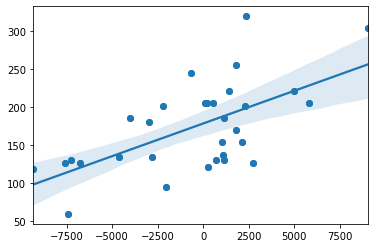

In [32]:
ax = plt.scatter(x=CX[:,0], y=CY[:,0])
#plt.title("1st component")
#plt.xlabel("Canonical X")
#plt.ylabel("Canonical Y")
sns.regplot(x=CX[:,0], y=CY[:,0])
#ax.get_xaxis().set_visible(False)
plt.show()

### 2nd plot

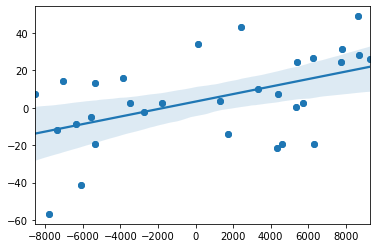

In [33]:
plt.scatter(x=CX[:,1], y=CY[:,1])
#plt.title("2nd component")
#plt.xlabel("Canonical X")
#plt.ylabel("Canonical Y")
sns.regplot(x=CX[:,1], y=CY[:,1])
plt.show()

### 3rd plot

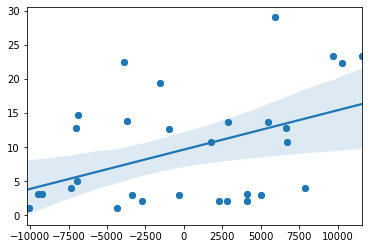

In [34]:
plt.scatter(x=CX[:,2], y=CY[:,2])
#plt.title("3rd component")
#plt.xlabel("Canonical X")
#plt.ylabel("Canonical Y")
sns.regplot(x=CX[:,2], y=CY[:,2])
plt.show()

## explained variance

In [35]:
# contribution
evX = np.mean(cca_ev[0], axis=0)
evY = np.mean(cca_ev[1], axis=0)

In [36]:
evX

array([[0.59913795, 0.54039007, 0.55206857, ..., 0.59844468, 4.61551817,
        0.64239451],
       [0.56051726, 0.416082  , 0.45327441, ..., 0.59053139, 9.19540553,
        0.6749356 ],
       [0.6523935 , 0.44194559, 0.57145333, ..., 0.66159256, 6.70569748,
        0.60532621],
       [0.54252128, 0.3563102 , 0.53583325, ..., 0.68683919, 5.26587812,
        0.67944094],
       [0.56510784, 0.41906358, 0.59930165, ..., 0.70846112, 4.63941611,
        0.64620655]])

In [37]:
evY

array([[0.21050868, 0.42377347, 0.74242508, 0.24261394],
       [0.15687845, 0.26577209, 0.62990086, 0.31654616],
       [0.15491184, 0.38075843, 0.418784  , 0.32651049],
       [0.23562189, 0.33126424, 0.82234182, 0.4314348 ],
       [0.17896336, 0.27237101, 0.85468298, 0.34966954]])

### ADOS

#### ADOS_1st comp

In [38]:
#color 설정
cmap = cm.RdBu_r

## 2단계 최대값과 최소값 결정
vmax = 1.2
vmin = 0
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

## 컬러바 생성
colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)

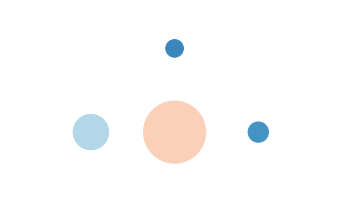

In [39]:

#plot 생성
circle_center_t = (0, 1) # 원의 중심
circle_center_s = (-2, -1)
circle_center_c = (0, -1)
circle_center_r = (2, -1)

circle_radius_t = evY[0][0]    # 원의 반지름
circle_radius_s = evY[0][1]
circle_radius_c = evY[0][2]
circle_radius_r = evY[0][3]

# 원의 객체 c 생성 (색채우기: 흰색, 둘레: 파란색)
c_t = plt.Circle(circle_center_t, circle_radius_t, color=cmap(norm(circle_radius_t)))
c_s = plt.Circle(circle_center_s, circle_radius_s, color=cmap(norm(circle_radius_s)))
c_c = plt.Circle(circle_center_c, circle_radius_c, color=cmap(norm(circle_radius_c)))
c_r = plt.Circle(circle_center_r, circle_radius_r, color=cmap(norm(circle_radius_r)))

# 축 설정
a = plt.axes(xlim=(-4, 4), ylim=(-3, 2))
a.add_patch(c_t)         # 원의 객체 c를 패치
a.add_patch(c_s) 
a.add_patch(c_c) 
a.add_patch(c_r) 

#cbar = plt.colorbar(colormapping, ax=plt.gca())
a.set_aspect('equal')  # X, Y축 1:1 비율로 설정
#plt.title("1st compoent_ADOS")
plt.axis('off')

plt.show() 

#### ADOS_2nd comp

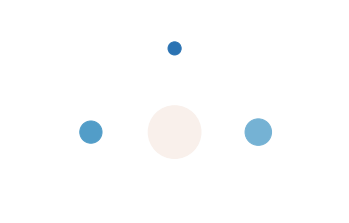

In [40]:
circle_center_t = (0, 1) # 원의 중심
circle_center_s = (-2, -1)
circle_center_c = (0, -1)
circle_center_r = (2, -1)

circle_radius_t = evY[1][0]    # 원의 반지름
circle_radius_s = evY[1][1]
circle_radius_c = evY[1][2]
circle_radius_r = evY[1][3]

# 원의 객체 c 생성 (색채우기: 흰색, 둘레: 파란색)
c_t = plt.Circle(circle_center_t, circle_radius_t, color=cmap(norm(circle_radius_t)))
c_s = plt.Circle(circle_center_s, circle_radius_s, color=cmap(norm(circle_radius_s)))
c_c = plt.Circle(circle_center_c, circle_radius_c, color=cmap(norm(circle_radius_c)))
c_r = plt.Circle(circle_center_r, circle_radius_r, color=cmap(norm(circle_radius_r)))

# 축 설정
a = plt.axes(xlim=(-4, 4), ylim=(-3, 2))
a.add_patch(c_t)         # 원의 객체 c를 패치
a.add_patch(c_s) 
a.add_patch(c_c) 
a.add_patch(c_r) 

#cbar = plt.colorbar(colormapping, ax=plt.gca())
a.set_aspect('equal')  # X, Y축 1:1 비율로 설정
#plt.title("2nd compoent_ADOS")
plt.axis('off')

plt.show() 

#### ADOS_3rd comp

In [41]:
evY[0]

array([0.21050868, 0.42377347, 0.74242508, 0.24261394])

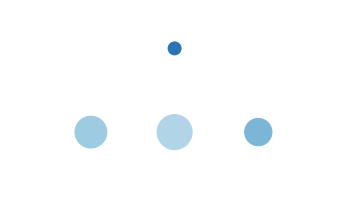

In [42]:
circle_center_t = (0, 1) # 원의 중심
circle_center_s = (-2, -1)
circle_center_c = (0, -1)
circle_center_r = (2, -1)

circle_radius_t = evY[2][0]    # 원의 반지름
circle_radius_s = evY[2][1]
circle_radius_c = evY[2][2]
circle_radius_r = evY[2][3]

# 원의 객체 c 생성 (색채우기: 흰색, 둘레: 파란색)
c_t = plt.Circle(circle_center_t, circle_radius_t, color=cmap(norm(circle_radius_t)))
c_s = plt.Circle(circle_center_s, circle_radius_s, color=cmap(norm(circle_radius_s)))
c_c = plt.Circle(circle_center_c, circle_radius_c, color=cmap(norm(circle_radius_c)))
c_r = plt.Circle(circle_center_r, circle_radius_r, color=cmap(norm(circle_radius_r)))

# 축 설정
a = plt.axes(xlim=(-4, 4), ylim=(-3, 2))
a.add_patch(c_t)         # 원의 객체 c를 패치
a.add_patch(c_s) 
a.add_patch(c_c) 
a.add_patch(c_r) 

#cbar = plt.colorbar(colormapping, ax=plt.gca(),location='bottom')
a.set_aspect('equal')  # X, Y축 1:1 비율로 설정
#plt.title("3rd compoent_ADOS")
plt.axis('off')

plt.show() 

In [43]:
circle_radius_t = evY[2][0]    # 원의 반지름
circle_radius_s = evY[2][1]
circle_radius_c = evY[2][2]
circle_radius_r = evY[2][3]

In [44]:
print(circle_radius_t)
print(circle_radius_s)
print(circle_radius_c)
print(circle_radius_r)

0.1549118426554124
0.3807584337388983
0.4187840048609323
0.32651048908003294
